<a href="https://colab.research.google.com/github/xiaoshaoyc/CSCI-4962/blob/main/CSCI4962_HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task0

Init.

We used [MNIST](http://yann.lecun.com/exdb/mnist/) dataset.

In [1]:
# init
import math
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
import torchvision
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt


In [2]:
def transform1(x):
  # transformation for raw image data
  return torch.tensor(np.array(x).reshape(-1) / 255)

def y_trans(y):
  # transformation for label
  return (y == 1) * 1.0

# Here, we store all the data in memory to accelerate training
class Mem_dataset(torch.utils.data.Dataset):
  def __init__(self, dataset) -> None:
    super().__init__()
    self.cache = {}
    self.dataset = dataset

  def __getitem__(self, index):
    if index in self.cache:
      return self.cache[index]
    else:
      item = self.dataset[index]
      self.cache[index] = item
      return item

  def __len__(self):
    return len(self.dataset) 

In [3]:
# fetch the dataset
train_dataset = torchvision.datasets.MNIST(root='', train=True, download=True, transform=transform1, target_transform=y_trans)

train_dataset_opt = Mem_dataset(train_dataset)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST/raw/train-images-idx3-ubyte.gz to MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/raw



Here, I try to make some guesses about the features that our decision tree may choose. Since 1's are more 'thin' than not 1's. Our decision tree may firstly consider middle-left and middle-right pixels as nodes. I also noticed that our dataset is unbalanced, which may be a problem for impurity measurement. We will deal with that problem later.

number of 1's = 6742
number of not 1's = 53258


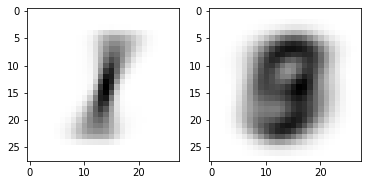

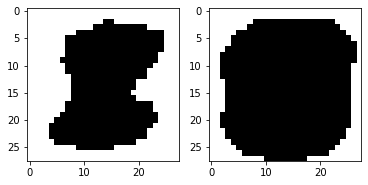

In [4]:
# sample analyze
num1_list = list(filter(lambda x: x[1] == 1, train_dataset_opt))
not1_list = list(filter(lambda x: x[1] != 1, train_dataset_opt))

print(f'number of 1\'s = {len(num1_list)}')
print(f'number of not 1\'s = {len(not1_list)}')

num1_X = np.array(list( map(lambda x: x[0].numpy(), num1_list) ))
not1_X = np.array(list( map(lambda x: x[0].numpy(), not1_list) ))
num1_Y = np.array(list( map(lambda x: x[1], num1_list) ))
not1_Y = np.array(list( map(lambda x: x[1], not1_list) ))

fig, ax_list0 = plt.subplots(1, 2, figsize=(5, 10), constrained_layout=True)
ax_list0[0].imshow(num1_X.sum(axis=0).reshape(28, 28), cmap='binary')
ax_list0[1].imshow(not1_X.sum(axis=0).reshape(28, 28), cmap='binary')

fig, ax_list1 = plt.subplots(1, 2, figsize=(5, 10), constrained_layout=True)
ax_list1[0].imshow(num1_X.sum(axis=0).reshape(28, 28) > (len(num1_X) * 0.001), cmap='binary')
ax_list1[1].imshow(not1_X.sum(axis=0).reshape(28, 28) > (len(not1_X) * 0.001), cmap='binary')

# Task 1




In [5]:
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

In [6]:
X = np.concatenate([num1_X, not1_X])
Y = np.concatenate([num1_Y, not1_Y])

Here we tried different input parameters. Our basic model is the first `dt`.(dt with `gini`)

Using entroy as criterion reduces the fit time. Limiting the max_depth also reduces the fit time, but at the cost of 1% accuracy(maybe a little underfit). `dt4` limits the number of features that each node can consider, reducing the fit time significantly without sacrificing accuracy. It is possible that we have too many redundant features, thus limiting the features will not impact the model too much.

In [7]:
def avg_print_cv(cv_ret, prefix=""):
  avg_fit_time = np.mean(cv_ret['fit_time'])
  avg_test_score = np.mean(cv_ret['test_score'])
  avg_pred_time = np.mean(cv_ret['score_time'])
  print(f'{prefix}avg_fit_time = {avg_fit_time}s')
  print(f'{prefix}avg_pred_time = {avg_pred_time}s')
  print(f'{prefix}avg_test_score = {avg_test_score}')
  print()
  return avg_fit_time, avg_test_score

dt = DecisionTreeClassifier(criterion='gini', random_state=0)
cv_ret = cross_validate(dt, X, Y, scoring='accuracy', cv=10)
dt_m = avg_print_cv(cv_ret, '[default dt]')

dt2 = DecisionTreeClassifier(criterion='entropy', random_state=0)
cv_ret2 = cross_validate(dt2, X, Y, scoring='accuracy', cv=10)
dt_m2 = avg_print_cv(cv_ret2, '[entropy dt]')

dt3 = DecisionTreeClassifier(criterion='gini', max_depth=5, random_state=0)
cv_ret3 = cross_validate(dt3, X, Y, scoring='accuracy', cv=10)
dt_m3 = avg_print_cv(cv_ret3, '[dt max_depth=5]')

dt4 = DecisionTreeClassifier(criterion='gini', max_features=100, random_state=0)
cv_ret4 = cross_validate(dt4, X, Y, scoring='accuracy', cv=10)
dt_m4 = avg_print_cv(cv_ret4, '[dt max_features=100]')

dt5 = DecisionTreeClassifier(criterion='entropy', max_depth=5, max_features=100, random_state=0)
cv_ret5 = cross_validate(dt5, X, Y, scoring='accuracy', cv=10)
dt_m5 = avg_print_cv(cv_ret5, '[entropy dt max_d=5,max_f=100]')

dt6 = DecisionTreeClassifier(criterion='entropy', max_depth=15, max_features=100, random_state=0)
cv_ret6 = cross_validate(dt6, X, Y, scoring='accuracy', cv=10)
dt_m6 = avg_print_cv(cv_ret6, '[entropy dt max_d=15,max_f=100]')

[default dt]avg_fit_time = 11.24409739971161s
[default dt]avg_pred_time = 0.01398167610168457s
[default dt]avg_test_score = 0.98675

[entropy dt]avg_fit_time = 6.966635394096374s
[entropy dt]avg_pred_time = 0.01187739372253418s
[entropy dt]avg_test_score = 0.9888

[dt max_depth=5]avg_fit_time = 5.782234811782837s
[dt max_depth=5]avg_pred_time = 0.01307675838470459s
[dt max_depth=5]avg_test_score = 0.9760666666666665

[dt max_features=100]avg_fit_time = 1.628520393371582s
[dt max_features=100]avg_pred_time = 0.013470149040222168s
[dt max_features=100]avg_test_score = 0.98715

[entropy dt max_d=5,max_f=100]avg_fit_time = 0.8838881254196167s
[entropy dt max_d=5,max_f=100]avg_pred_time = 0.012567973136901856s
[entropy dt max_d=5,max_f=100]avg_test_score = 0.9658999999999999

[entropy dt max_d=15,max_f=100]avg_fit_time = 1.1302621126174928s
[entropy dt max_d=15,max_f=100]avg_pred_time = 0.013444638252258301s
[entropy dt max_d=15,max_f=100]avg_test_score = 0.9891166666666666



Here we try to mitigate the effect of unbalanced dataset by weighting different classes. It seems to work, but the improvement is not significant.

In [8]:
X = np.concatenate([num1_X, not1_X])
Y = np.concatenate([num1_Y, not1_Y])
weights = {0:len(num1_X), 1:len(not1_X)}
dt_s = DecisionTreeClassifier(criterion='gini', class_weight=weights, random_state=0)
cv_ret_s = cross_validate(dt_s, X, Y, scoring='accuracy', cv=10)
dt_m_s = avg_print_cv(cv_ret_s, '[Balance dt]')

dt_s2 = DecisionTreeClassifier(criterion='entropy', class_weight=weights, random_state=0)
cv_ret_s2 = cross_validate(dt_s2, X, Y, scoring='accuracy', cv=10)
dt_m_s2 = avg_print_cv(cv_ret_s2, '[B entropy dt]')

dt_s3 = DecisionTreeClassifier(criterion='entropy', max_depth=15, max_features=100, class_weight=weights, random_state=0)
cv_ret_s3 = cross_validate(dt_s3, X, Y, scoring='accuracy', cv=10)
dt_m_s3 = avg_print_cv(cv_ret_s3, '[B entropy dt max_d=15,max_f=100]')

[Balance dt]avg_fit_time = 15.282448935508729s
[Balance dt]avg_pred_time = 0.015084576606750489s
[Balance dt]avg_test_score = 0.9888333333333333

[B entropy dt]avg_fit_time = 7.052558875083923s
[B entropy dt]avg_pred_time = 0.01312875747680664s
[B entropy dt]avg_test_score = 0.9895000000000002

[B entropy dt max_d=15,max_f=100]avg_fit_time = 1.112791156768799s
[B entropy dt max_d=15,max_f=100]avg_pred_time = 0.012908077239990235s
[B entropy dt max_d=15,max_f=100]avg_test_score = 0.9889666666666667



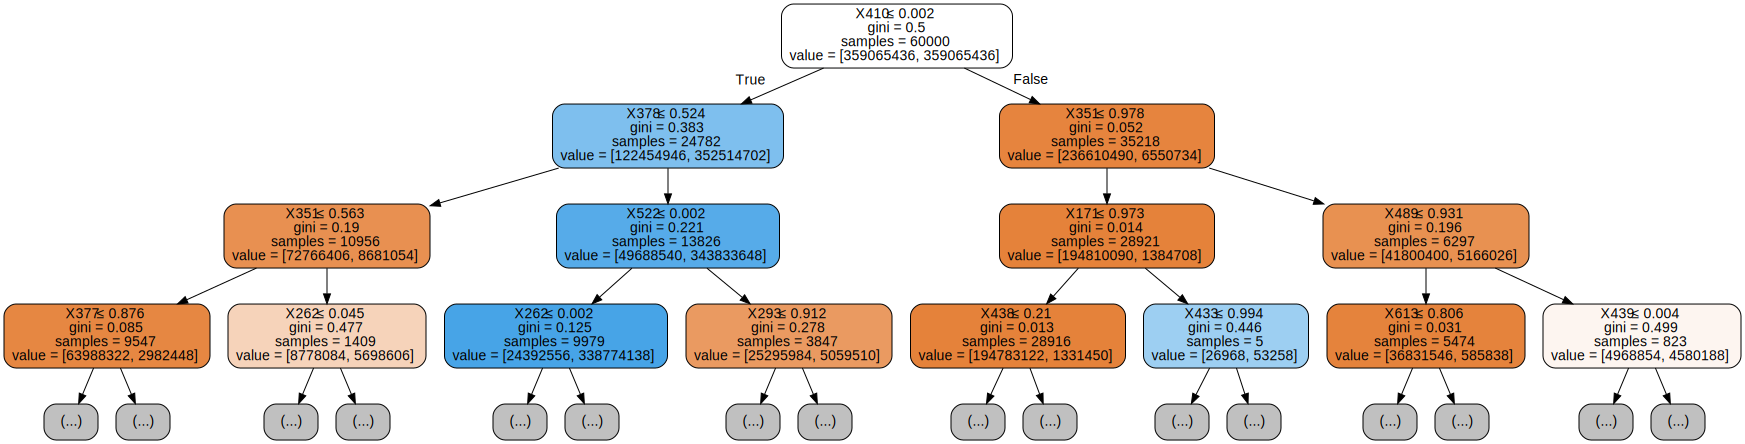

In [ ]:
"""
Here I verified my guess, X410 is (13, 17), a pixel in the middle-right.
X378, X351 are also pixels in the middle.
"""

from sklearn import tree
import graphviz 
dt_s.fit(X,Y)
dot_data = tree.export_graphviz(dt_s, out_file=None, 
                     filled=True, rounded=True,  
                     special_characters=True,
                     max_depth=3)  
graph = graphviz.Source(dot_data)  
graph 

# Task2

We choose **Random Forest** as our bagging ensemble method, and we choose **AdaBoost** as our boosting ensemble method. We use 10-fold cross validation to find the effective of both the models.

**Random Forest** has `fit_time=20.58s`, `predict_time=0.1654s`, and `accuracy=0.9949`. **AdaBoost** has `fit_time=143.4s`, `pred_time=1.375s`, and `accuracy=0.9905`. Random Forest and AdaBoost have similar accuracy. However, AdaBoost has a significantly longer fit time and predict time. Our guess is that AdaBoost has dependencies on weak learners while RandomForest can parallel the model-building process.

In [15]:
"""
We perform a 10-fold cross validation
"""

dt_rt = RandomForestClassifier(n_estimators=100, criterion="gini", max_depth=10, random_state=0)
cv_ret = cross_validate(dt_rt, X, Y, scoring='accuracy', cv=10)
_ = avg_print_cv(cv_ret, '[RandomForest]')

dt_ab = AdaBoostClassifier(n_estimators=100, random_state=0)
cv_ret = cross_validate(dt_ab, X, Y, scoring='accuracy', cv=10)
_ = avg_print_cv(cv_ret, '[AdaBoost]')


[RandomForest]avg_fit_time = 20.58387064933777s
[RandomForest]avg_pred_time = 0.16544511318206787s
[RandomForest]avg_test_score = 0.9948666666666668

[AdaBoost]avg_fit_time = 143.41250908374786s
[AdaBoost]avg_pred_time = 1.3748717784881592s
[AdaBoost]avg_test_score = 0.9905000000000002



In [16]:
"""
try bagging & boosting with balanced dataset, no obvious difference
"""

dt_rt = RandomForestClassifier(n_estimators=100, criterion="gini", max_depth=10, random_state=0)
cv_ret = cross_validate(dt_rt, X, Y, scoring='accuracy', cv=10)
_ = avg_print_cv(cv_ret, '[RandomForest]')

base_dt = DecisionTreeClassifier(criterion='gini', class_weight=weights, max_depth=1, random_state=0)
dt_ab = AdaBoostClassifier(base_estimator=base_dt, n_estimators=100, random_state=0)
cv_ret = cross_validate(dt_ab, X, Y, scoring='accuracy', cv=10)
_ = avg_print_cv(cv_ret, '[AdaBoost]')


[RandomForest]avg_fit_time = 16.14280734062195s
[RandomForest]avg_pred_time = 0.11262373924255371s
[RandomForest]avg_test_score = 0.9948666666666668

[AdaBoost]avg_fit_time = 121.70339148044586s
[AdaBoost]avg_pred_time = 1.0903376579284667s
[AdaBoost]avg_test_score = 0.9851666666666666



# Task3

For task1 and task2, we choose accuracy as our measurement because our problem(1's or not 1's) is a neutral problem, which means that we do not favor in one side when making predictions. Thus, we want to have an accuracy as high as possible when tuning the model.

However, since my dataset is unbalanced, our model may be more likely to predict a image as not 1's. (Since not 1's has a larger population) In this case, **the balanced accuracy is a better choice**. The [balanced accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html#sklearn-metrics-balanced-accuracy-score) defined as the average of recall obtained on each class. We will use **balanced accuracy** for our comparison.

**Decision Tree** has `fit_time=0.6746s`, `predict_time=0.005702s`, and `B_accuracy=0.9891`  **Random Forest** has `fit_time=20.58s`, `predict_time=0.1654s`, and `B_accuracy=0.9949`. **AdaBoost** has `fit_time=143.4s`, `pred_time=1.375s`, and `B_accuracy=0.9905`. The decision tree is lighting fast for training and predicting compared to other algorithms. However, decision tree's accuracy is slightly lower than other algorithms. AdaBoost is very slow in training and predicting since the 'pipeline' mechanism of the model. It should have better performance (low bias, strong prediction power), but it is not significant in our case because our base model has a good accuracy already. (our task is too easy)

In [14]:
scoring = 'balanced_accuracy'
dt6 = DecisionTreeClassifier(criterion='entropy', max_depth=15, max_features=100, random_state=0)
cv_ret6 = cross_validate(dt6, X, Y, scoring=scoring, cv=10)
dt_m6 = avg_print_cv(cv_ret6, '[DecisionTree]')

dt_rt = RandomForestClassifier(n_estimators=100, criterion="gini", max_depth=10, random_state=0)
cv_ret = cross_validate(dt_rt, X, Y, scoring=scoring, cv=10)
_ = avg_print_cv(cv_ret, '[RandomForest]')

dt_ab = AdaBoostClassifier(n_estimators=100, random_state=0)
cv_ret = cross_validate(dt_ab, X, Y, scoring=scoring, cv=10)
_ = avg_print_cv(cv_ret, '[AdaBoost]')

[DecisionTree]avg_fit_time = 0.6853239059448242s
[DecisionTree]avg_pred_time = 0.009248924255371094s
[DecisionTree]avg_test_score = 0.9753446844977152

[RandomForest]avg_fit_time = 13.27408583164215s
[RandomForest]avg_pred_time = 0.07858688831329345s
[RandomForest]avg_test_score = 0.9814987006134098

[AdaBoost]avg_fit_time = 92.16140928268433s
[AdaBoost]avg_pred_time = 0.5632796049118042s
[AdaBoost]avg_test_score = 0.9796871380344516



The graph(graph for `dt_d1`) below shows that we have more leaf nodes that predict the input as `not 1's`, which could be the evidence that "our model may be more likely to predict an image as not 1's". In addition, when we switch from `balanced accuracy` to `accuracy` as metric, the test score increased, which could also be an evidence.

In [17]:
scoring = 'accuracy'
dt6 = DecisionTreeClassifier(criterion='entropy', max_depth=15, max_features=100, random_state=0)
cv_ret6 = cross_validate(dt6, X, Y, scoring=scoring, cv=10)
dt_m6 = avg_print_cv(cv_ret6, '[DecisionTree]')

dt_rt = RandomForestClassifier(n_estimators=100, criterion="gini", max_depth=10, random_state=0)
cv_ret = cross_validate(dt_rt, X, Y, scoring=scoring, cv=10)
_ = avg_print_cv(cv_ret, '[RandomForest]')

dt_ab = AdaBoostClassifier(n_estimators=100, random_state=0)
cv_ret = cross_validate(dt_ab, X, Y, scoring=scoring, cv=10)
_ = avg_print_cv(cv_ret, '[AdaBoost]')

[DecisionTree]avg_fit_time = 0.6806240320205689s
[DecisionTree]avg_pred_time = 0.006224274635314941s
[DecisionTree]avg_test_score = 0.9891166666666666

[RandomForest]avg_fit_time = 13.149167561531067s
[RandomForest]avg_pred_time = 0.07483973503112792s
[RandomForest]avg_test_score = 0.9948666666666668

[AdaBoost]avg_fit_time = 91.36987471580505s
[AdaBoost]avg_pred_time = 0.5473012208938599s
[AdaBoost]avg_test_score = 0.9905000000000002



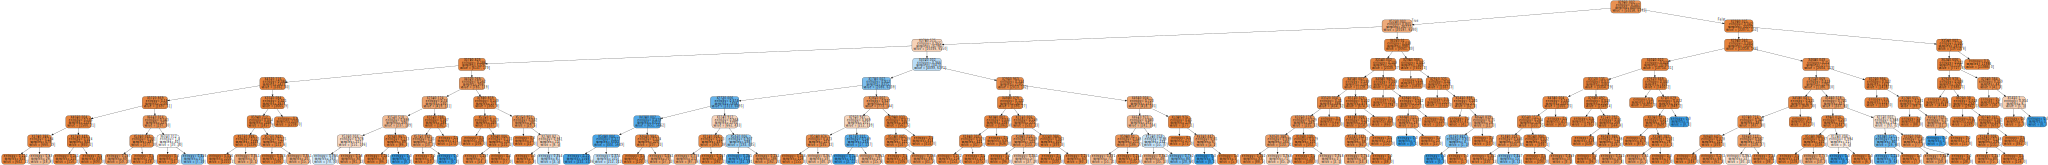

In [25]:
from sklearn import tree
import graphviz 
dt_d1 = DecisionTreeClassifier(criterion='entropy', max_depth=8, max_features=100, random_state=0)
dt_d1.fit(X,Y)
dot_data = tree.export_graphviz(dt_d1, out_file=None, 
                     filled=True, rounded=True,  
                     special_characters=True,
                     max_depth=15)  
graph = graphviz.Source(dot_data)  
graph 

In [16]:
# AdaBoost is very very slow...
X = np.concatenate([num1_X, not1_X])
Y = np.concatenate([num1_Y, not1_Y])
weights = {0:len(num1_X), 1:len(not1_X)}
scoring = 'balanced_accuracy'
base_dt = DecisionTreeClassifier(criterion='gini', class_weight=weights, max_depth=1, max_features=100, random_state=0)
dt_ab = AdaBoostClassifier(base_estimator=base_dt, n_estimators=100, random_state=0)
cv_ret = cross_validate(dt_ab, X, Y, scoring=scoring, cv=10)
_ = avg_print_cv(cv_ret, '[AdaBoost]')

[AdaBoost]avg_fit_time = 20.393456172943115s
[AdaBoost]avg_pred_time = 0.5481722593307495s
[AdaBoost]avg_test_score = 0.983463027901994



### Additional test, just for self-learning

In [18]:
scoring = 'f1'
dt6 = DecisionTreeClassifier(criterion='entropy', max_depth=15, max_features=100, random_state=0)
cv_ret6 = cross_validate(dt6, X, Y, scoring=scoring, cv=10)
dt_m6 = avg_print_cv(cv_ret6, '[DecisionTree]')

dt_rt = RandomForestClassifier(n_estimators=100, criterion="gini", max_depth=10, random_state=0)
cv_ret = cross_validate(dt_rt, X, Y, scoring=scoring, cv=10)
_ = avg_print_cv(cv_ret, '[RandomForest]')

dt_ab = AdaBoostClassifier(n_estimators=100, random_state=0)
cv_ret = cross_validate(dt_ab, X, Y, scoring=scoring, cv=10)
_ = avg_print_cv(cv_ret, '[AdaBoost]')

[DecisionTree]avg_fit_time = 0.6876931190490723s
[DecisionTree]avg_pred_time = 0.008095288276672363s
[DecisionTree]avg_test_score = 0.9518611434458762

[RandomForest]avg_fit_time = 13.071831560134887s
[RandomForest]avg_pred_time = 0.07686195373535157s
[RandomForest]avg_test_score = 0.9768610302965358

[AdaBoost]avg_fit_time = 91.81991443634033s
[AdaBoost]avg_pred_time = 0.5647037029266357s
[AdaBoost]avg_test_score = 0.9580494489612464



In [19]:
scoring = 'recall'
dt6 = DecisionTreeClassifier(criterion='entropy', max_depth=15, max_features=100, random_state=0)
cv_ret6 = cross_validate(dt6, X, Y, scoring=scoring, cv=10)
dt_m6 = avg_print_cv(cv_ret6, '[DecisionTree]')

dt_rt = RandomForestClassifier(n_estimators=100, criterion="gini", max_depth=10, random_state=0)
cv_ret = cross_validate(dt_rt, X, Y, scoring=scoring, cv=10)
_ = avg_print_cv(cv_ret, '[RandomForest]')

dt_ab = AdaBoostClassifier(n_estimators=100, random_state=0)
cv_ret = cross_validate(dt_ab, X, Y, scoring=scoring, cv=10)
_ = avg_print_cv(cv_ret, '[AdaBoost]')

[DecisionTree]avg_fit_time = 0.6872010231018066s
[DecisionTree]avg_pred_time = 0.008021306991577149s
[DecisionTree]avg_test_score = 0.9575803934498296

[RandomForest]avg_fit_time = 13.046009016036987s
[RandomForest]avg_pred_time = 0.07457578182220459s
[RandomForest]avg_test_score = 0.9642554126827123

[AdaBoost]avg_fit_time = 94.38157386779785s
[AdaBoost]avg_pred_time = 0.5499269247055054s
[AdaBoost]avg_test_score = 0.965739531816683



 # Miscellaneous

In [18]:
# test binary F1 return the item I want
from sklearn.metrics import make_scorer, f1_score
f1_n = make_scorer(f1_score, average=None)
f1 = make_scorer(f1_score, average='binary')

dt_s3_m2 = DecisionTreeClassifier(criterion='entropy', max_depth=15, max_features=100, class_weight=weights, random_state=0)
dt_s3_m2.fit(X, Y)
Y_pred = dt_s3_m2.predict(X)
ret = f1_score(Y, Y_pred, average=None)
print(ret)

dt_s3_m3 = DecisionTreeClassifier(criterion='entropy', max_depth=15, max_features=100, class_weight=weights, random_state=0)
dt_s3_m3.fit(X, Y)
Y_pred = dt_s3_m3.predict(X)
ret = f1_score(Y, Y_pred, average='binary')
print(ret)

[0.99874051 0.99015285]
0.9901528512639625


In [10]:
# 100-fold cv for high acc
scoring = 'balanced_accuracy'
dt6_100f = DecisionTreeClassifier(criterion='entropy', max_depth=15, max_features=100, random_state=0)
cv_ret6_100f = cross_validate(dt6_100f, X, Y, scoring=scoring, cv=100)
dt_m6_100f = avg_print_cv(cv_ret6_100f, '[DecisionTree]')

[DecisionTree]avg_fit_time = 0.7832917451858521s
[DecisionTree]avg_pred_time = 0.0018535399436950685s
[DecisionTree]avg_test_score = 0.9756082457883337



In [13]:
dt_rt_100f = RandomForestClassifier(n_estimators=100, criterion="gini", max_depth=10, random_state=0)
cv_ret_100f = cross_validate(dt_rt_100f, X, Y, scoring=scoring, cv=100)
_ = avg_print_cv(cv_ret_100f, '[RandomForest]')

[RandomForest]avg_fit_time = 14.84400509595871s
[RandomForest]avg_pred_time = 0.017210323810577393s
[RandomForest]avg_test_score = 0.981067851013191



In [ ]:
dt_ab_100f = AdaBoostClassifier(n_estimators=100, random_state=0)
cv_ret_100f = cross_validate(dt_ab_100f, X, Y, scoring=scoring, cv=100)
_ = avg_print_cv(cv_ret_100f, '[AdaBoost]')

In [ ]:
# not used
scoring = 'balanced_accuracy'
dt = DecisionTreeClassifier(criterion='gini', random_state=0)
cv_ret = cross_validate(dt, X, Y, scoring=scoring, cv=10)
dt_m = avg_print_cv(cv_ret, '[dt]')

dt2 = DecisionTreeClassifier(criterion='entropy', random_state=0)
cv_ret2 = cross_validate(dt2, X, Y, scoring=scoring, cv=10)
dt_m2 = avg_print_cv(cv_ret2, '[dt2]')

dt3 = DecisionTreeClassifier(criterion='gini', max_depth=5, random_state=0)
cv_ret3 = cross_validate(dt3, X, Y, scoring=scoring, cv=10)
dt_m3 = avg_print_cv(cv_ret3, '[dt3]')

dt4 = DecisionTreeClassifier(criterion='gini', max_features=100, random_state=0)
cv_ret4 = cross_validate(dt4, X, Y, scoring=scoring, cv=10)
dt_m4 = avg_print_cv(cv_ret4, '[dt4]')

dt5 = DecisionTreeClassifier(criterion='entropy', max_depth=5, max_features=100, random_state=0)
cv_ret5 = cross_validate(dt5, X, Y, scoring=scoring, cv=10)
dt_m5 = avg_print_cv(cv_ret5, '[dt5]')

avg_fit_time = 11.022568368911744s
avg_pred_time = 0.018310546875s
avg_test_score = 0.970967258894969

avg_fit_time = 6.388981008529663s
avg_pred_time = 0.01839790344238281s
avg_test_score = 0.974194181623728

avg_fit_time = 5.257892203330994s
avg_pred_time = 0.01673116683959961s
avg_test_score = 0.9453221077531827

avg_fit_time = 1.3845264911651611s
avg_pred_time = 0.01750335693359375s
avg_test_score = 0.9715808878646449

avg_fit_time = 0.7975490093231201s
avg_pred_time = 0.017349743843078615s
avg_test_score = 0.918030402944764



In [23]:
# not used
scoring = 'recall'
dt_s = DecisionTreeClassifier(criterion='gini', class_weight=weights, random_state=0)
cv_ret_s = cross_validate(dt_s, X, Y, scoring=scoring, cv=10)
dt_m_s = avg_print_cv(cv_ret_s)

dt_s2 = DecisionTreeClassifier(criterion='entropy', class_weight=weights, random_state=0)
cv_ret_s2 = cross_validate(dt_s2, X, Y, scoring=scoring, cv=10)
dt_m_s2 = avg_print_cv(cv_ret_s2)

dt_s3 = DecisionTreeClassifier(criterion='entropy', max_depth=15, max_features=100, class_weight=weights, random_state=0)
cv_ret_s3 = cross_validate(dt_s3, X, Y, scoring=scoring, cv=10)
dt_m_s3 = avg_print_cv(cv_ret_s3)

avg_fit_time = 13.343000197410584s
avg_pred_time = 0.01958143711090088s
avg_test_score = 0.9492735465435764

avg_fit_time = 6.760175275802612s
avg_pred_time = 0.017557525634765626s
avg_test_score = 0.9586178700956148

avg_fit_time = 1.0495509862899781s
avg_pred_time = 0.017020821571350098s
avg_test_score = 0.9608433893834487



In [24]:
scoring = 'balanced_accuracy'
dt_b = DecisionTreeClassifier(criterion='gini', class_weight=weights, random_state=0)
cv_ret_b = cross_validate(dt_b, X, Y, scoring=scoring, cv=10)
dt_m_b = avg_print_cv(cv_ret_b, '[dt_b]')

dt_b2 = DecisionTreeClassifier(criterion='entropy', class_weight=weights, random_state=0)
cv_ret_b2 = cross_validate(dt_b2, X, Y, scoring=scoring, cv=10)
dt_m_b2 = avg_print_cv(cv_ret_b2, '[dt_b2]')

dt_b3 = DecisionTreeClassifier(criterion='entropy', max_depth=15, max_features=100, class_weight=weights, random_state=0)
cv_ret_b3 = cross_validate(dt_b3, X, Y, scoring=scoring, cv=10)
dt_m_b3 = avg_print_cv(cv_ret_b3, '[dt_b3]')

[dt_b]avg_fit_time = 10.717323851585387s
[dt_b]avg_pred_time = 0.017659473419189452s
[dt_b]avg_test_score = 0.9715574176789747

[dt_b2]avg_fit_time = 6.011569666862488s
[dt_b2]avg_pred_time = 0.017207241058349608s
[dt_b2]avg_test_score = 0.976013636406542

[dt_b3]avg_fit_time = 0.9724507093429565s
[dt_b3]avg_pred_time = 0.017268991470336913s
[dt_b3]avg_test_score = 0.9766851379120677



In [ ]:
scoring = 'recall'
dt = DecisionTreeClassifier(criterion='gini', random_state=0)
cv_ret = cross_validate(dt, X, Y, scoring=scoring, cv=10)
dt_m = avg_print_cv(cv_ret)

dt2 = DecisionTreeClassifier(criterion='entropy', random_state=0)
cv_ret2 = cross_validate(dt2, X, Y, scoring=scoring, cv=10)
dt_m2 = avg_print_cv(cv_ret2)

dt3 = DecisionTreeClassifier(criterion='gini', max_depth=5, random_state=0)
cv_ret3 = cross_validate(dt3, X, Y, scoring=scoring, cv=10)
dt_m3 = avg_print_cv(cv_ret3)

dt4 = DecisionTreeClassifier(criterion='gini', max_features=100, random_state=0)
cv_ret4 = cross_validate(dt4, X, Y, scoring=scoring, cv=10)
dt_m4 = avg_print_cv(cv_ret4)

dt5 = DecisionTreeClassifier(criterion='entropy', max_depth=5, max_features=100, random_state=0)
cv_ret5 = cross_validate(dt5, X, Y, scoring=scoring, cv=10)
dt_m5 = avg_print_cv(cv_ret5)

avg_fit_time = 14.00842742919922s
avg_pred_time = 0.017385292053222656s
avg_test_score = 0.9506092977250248

avg_fit_time = 7.693921518325806s
avg_pred_time = 0.015551567077636719s
avg_test_score = 0.9553544345532476

avg_fit_time = 6.734702372550965s
avg_pred_time = 0.018751811981201173s
avg_test_score = 0.9056654577426091

avg_fit_time = 1.6619008302688598s
avg_pred_time = 0.015767121315002443s
avg_test_score = 0.9514986262226618

avg_fit_time = 0.9945934295654297s
avg_pred_time = 0.018022966384887696s
avg_test_score = 0.85628310803385

